In [1]:
# Import required packages #
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import numpy as np
from pyomo.core.base import (ConcreteModel,Set,Var,Objective,Constraint,
                             Param, NonNegativeReals,PositiveReals, Reals)
import os
import pandas as pd
import json
from pyomo.environ import *
import random
import math
import matplotlib.pyplot as plt
##Inegration##
from online_batches import online_batches
from ml_models import ml_model

# Funcion for generating randomized occupancy vector
def generate_occupancy_signal(time_array):
    # 24 hours of data plus one extra time step
    signal_length = 49    
    
    # Generate a signal of 0s intially
    signal = [0] * signal_length

    # Assume home between 6 PM and 8 AM 
    for i,time in enumerate(time_array):
        if time <= 800 or time >=  1800:
            signal[i] = 1
        
    # Set final time step value based on previous value
    signal[-1] = signal[-2]

    # Randomly set other values to 1 or 0
    for i in range(signal_length):
        if signal[i] == 0 and random.random() < 0.2:
            signal[i] = 1

    return signal

# Function for updating occupancy vector for next time step
def update_occupancy(Occupancy, time_array_new):
    del Occupancy[0]  # Delete the first element

    # Gennerate new time point data (Assume home between 6 PM and 8 AM, other points random)
    if (time_array_new[-1] <= 800 or time_array_new[-1] >=  1800) or random.random() < 0.2:
        new_val = 1
    else:
        new_val = 0
        
    Occupancy.append(new_val)
    return Occupancy

# Optimizer controller     
class controller:

    # Inital building temperature and SOC (should be fed back as input after first execution)
    inital_temp = 21
    inital_SoC = 6.5 # 50 percent
    
    def controller_model(self,T_out, Load, Ins_PV, tariff, Occupancy):
        ### PYOMO MODEL ###
        
        # Create the model object:
        m = ConcreteModel()

        # Indices for each timestep, here i= 1 to 48
        m.TS = Set(initialize=[i+1 for i in range(48)])

        # Time step between data in hours (30 minutes = 0.5 hours)
        m.dt = 0.5 

        # Load usage data as model parameter
        m.P_Load =  Param(m.TS,initialize={i: Load[i-1] for i in m.TS}) # Set as parameter of model

        # Tariff (assuming same price for export and import and constant)
        m.tariff = Param(m.TS, initialize= tariff) # $ per kwh

        ### INPUTS ###
        
        # Number of occupants
        occupants = 2

        # Minimum and maximum temperature of the house (comfort constraint)
        temp_min = 18 # Degrees
        temp_max = 24 # Degrees
        temp_pref_high = 21.1 # Degrees
        temp_pref_low = 20.9 # Degrees

        # Angle of panels
        panel_angle = 30  # Inclination in deg

        # Area of panels
        Area = 50 # m2

        # Panel efficency 
        eta_PV = 0.18 # 18% defined as PV_max (kW)/[Area (m2)*1 (kW/m2)]

        # Heat pump max output
        EHP_heat_max = 3 # kWth 

        # Battery max charge/discharge rate in kw
        BESS_max = 5 

        # Battery minimum SOC 
        SoC_min = 0

        # Battery maximum SOC 
        SoC_max = 13.5 # kWh

        # Battery charging efficency
        eta_ch = 0.95 

        # Battery discharging efficiency
        eta_dis = 0.95 

        # Battery self-consumption losses (typically very small values, assumed here to be zero for simplicity)
        BESS_losses = 0 

        # Building thermal capacitance which reflects its thermal inertia and therefore its ability to absorb, store and release heat
        Cb = 23.16 # kWh/K 

        # Building material thermal resistance which reflects its ability to resist heat flow
        Rb= 8.38 # K/kW 

        # Absorbed solar radiation which depends on the building structure
        SHGC = 0 # For buildings with double glazed windows, typical valuesfor the Solar Heat Gain Coefficient (SHGC) are in the range of 0.42 - 0.55. However, in this example we assume it to be zero.

        # Heat gain per occupant
        heat_gains = 0.12 # kW/occupant

        # Export limit in kW
        export_lim = 5

        ### PV MODEL ###

        # Parameters
        # Calculate the cosine of the panel inclination angle
        cosine_angle = math.cos(math.radians(panel_angle))
        m.PV_f=Param(m.TS,initialize={i: eta_PV*Area*Ins_PV[i-1] * cosine_angle for i in m.TS}) # PV forecasted power output: eta_PV*Ins_PV(t)*Area 

        # Decision variables
        m.PV_gen = Var(m.TS,initialize=0,domain=NonNegativeReals)  # Actual power output of the PV resulting from the optimization model
        m.PV_curt = Var(m.TS,initialize=0,domain=NonNegativeReals)  # PV curtailment resulting from the optimization model

        # Constraints
        # Curtailment constraint (actual production = forecasted production-curtailment)
        def PV_power_rule(model,i):
            return model.PV_gen[i]  == model.PV_f[i] - model.PV_curt[i]  
        m.con_PV = Constraint(m.TS, rule=PV_power_rule) 

        ### EHP MODEL ###

        # Parameters
        COP_T = 0.25* T_out + 1 # COP(T_out) as a linear function of the outdoor temperature with slope=4
        m.COP = Param(m.TS,initialize={i: COP_T[i-1] for i in m.TS}) # Store COP vector as time series parameter

        # Decision variables
        m.ehp_E_input = Var(m.TS,initialize=0,domain=NonNegativeReals) # EHP electrical power input (kW) 
        m.ehp_H_output = Var(m.TS,initialize=0,domain=NonNegativeReals) # EHP heat power output (kW) 

        # Constraints
        # The heat output is equal to the electric power input times the COP value
        def EHP_rule(model,i):
            return model.ehp_H_output[i]  == model.ehp_E_input[i]*m.COP[i]   
        m.con_EHP = Constraint(m.TS, rule=EHP_rule)
        # The heat output must be less than the max heat output
        def EHP_size(model,i):
            return model.ehp_H_output[i]<=EHP_heat_max
        m.size_EHP = Constraint(m.TS, rule=EHP_size)

        ### BESS MODEL ###

        # Bounds definitions for variables
        # Discharge cannot be greater than limit
        def BESS_ch_dis_rule(model,i):
            return (0,BESS_max)
        # SOC cannot be less than minimum value and more than maximum value
        def SoC_rule(model,i):
            return (SoC_min,SoC_max)

        # Decision variables
        m.BESS_ch = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # Battery charging (consuming) power
        m.BESS_dis = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # Battery discharging (generating) power 
        m.BESS_net = Var(m.TS,initialize=0,domain=Reals) # Battery net injection of power
        m.SoC = Var(m.TS,initialize=self.inital_SoC,bounds=SoC_rule) # Battery SOC

        # Constraints
        # Battery net injection is equal to the difference between the charging and discharging powers
        def BESS_net_inj_rule(model,i):
            return model.BESS_net[i]==model.BESS_dis[i]-model.BESS_ch[i] # Postive power implies discharging/generating
        m.BESS_injection_con = Constraint(m.TS,rule=BESS_net_inj_rule)
        # SOC at each time step is based in previous discharge and charge values
        def BESS_rule(model,i):
            if i==1: # SoC at the start of the time horizon is equal to the SoC at the end
                i0=model.TS[-1]
            else:
                i0=i-1
            return model.SoC[i]-model.SoC[i0] == ((eta_ch*model.BESS_ch[i0])-(model.BESS_dis[i0]/eta_dis)-BESS_losses)*model.dt
        m.BESS_oper = Constraint(m.TS, rule=BESS_rule)
        # Set inital SOC to 50 percent to avoid drift
        m.SoC_initial = Constraint(rule=lambda m: m.SoC[1] == self.inital_SoC)

        ### BUILDING MODEL ###

        # Parameters
        m.TS_aux = Set(initialize=[i+1 for i in range(49)]) # Auxiliary time set for temperature modelling
        m.Temp_Out = Param(m.TS, initialize={i: T_out[i-1] for i in m.TS}) # Prediction of outdoor temperature 
        m.Sol = Param(m.TS, initialize={i: SHGC*Ins_PV[i-1] for i in m.TS}) # The kWh solar gain, that is the heat increase of a structure resulting from solar radiation 
        Int_Heat_Gains_Data = heat_gains*occupants # Heat gain due to occupants 
        Int = [i*Int_Heat_Gains_Data for i in Occupancy] # Heat gain at each time step
        m.Int = Param(m.TS, initialize={i: Int[i-1] for i in m.TS}) # Heat coming from the presence of occupants in the building (metabolic gain)
        m.Occ = Param(m.TS_aux, initialize={i: Occupancy[i-1] for i in m.TS_aux})
        
        # Variables
        m.temp = Var(m.TS_aux, initialize=self.inital_temp, bounds=(temp_min,temp_max)) # Inside temperature of the building
        m.h_sh = Var(m.TS, initialize=0, domain=NonNegativeReals) # Heat delivered to the building for space heating (kWh)
        m.alpha = Var(m.TS,initialize=0,bounds=(0,1)) # Alpha (ventilation variable)

        # Constraints
        # Set inital temperature to inital value input (cant be controlled)
        m.temp_initial = Constraint(rule=lambda m: m.temp[1] == self.inital_temp)
        # Accommodate the occupant preferences to keep temperature at preference (21 deg) when people are home 
        '''def temp_constraint(model, i):
            if model.Occ[i] > 0 and i!=1:
                return model.temp[i] == temp_pref
            else:
                return Constraint.Skip
        m.temp_constraint = Constraint(m.TS_aux, rule=temp_constraint)'''
        def temp_constraint(model, i):
            if model.Occ[i] > 0 and i!=1:
                return (temp_pref_low, model.temp[i], temp_pref_high)
            else:
                return Constraint.Skip
        m.temp_constraint = Constraint(m.TS_aux, rule=temp_constraint)
        
        # Temperature evolution depends on the heat transfers and building characteristics.
        # The heat energy from the pump is equal to the output heat power of the pump multiplied by the time step length (joins heat pump and building model)
        m.building_system = Constraint(m.TS, rule=lambda m, i: m.temp[i+1] == m.temp[i]+(m.ehp_H_output[i] + (1-m.alpha[i])*(m.Int[i]+m.Sol[i])-(m.temp[i]-m.Temp_Out[i])*(1/Rb))*m.dt*(1/Cb))

        ### POWER FLOW MODEL ###

        # Variables
        m.P_net = Var(m.TS,initialize=0,bounds=(-export_lim, None)) # Power flowing in is positive

        # Constraints
        
        # Net power flowing in or out is equal to the difference between the load and generation of the house. The net flow is either equal to the flow in (P_in) or the flow out (P_out). If net power is positive P_out should be 0 and if net power is negative P_in should be negative.
        def Power_flow(model,i):
            return model.P_net[i] == model.P_Load[i]+model.ehp_E_input[i] - m.BESS_net[i] -model.PV_gen[i]
        m.Power_flow_in_con = Constraint(m.TS,rule=Power_flow)

        ### OBJECTIVE FUNCTION ###

        # Define the objective function (minimize the total cost), where the cost is equal to the energy (net power flow multiplied by the time step) multiplied by the tariff for each direction
        m.objective = pyo.Objective(expr=sum((m.tariff[i]*m.P_net[i])*m.dt for i in m.TS),sense=minimize)

        ### USE MODEL ###
        solver = pyo.SolverFactory('ipopt')
        results = solver.solve(m)

        ### RESULTS  ###
        print(f"Total cost: {pyo.value(m.objective):.2f}")
        # Uncomment this line to see results printed out
        # m.display()

        ### SET INITAL VALUES FOR NEXT EXECUTION ###
        self.inital_temp = value(m.temp[2])
        self.inital_SoC = value(m.SoC[2])

        return m
    

def plot_forecast(m, time_values):
    # Extract values
    BESS_net_values = [pyo.value(m.BESS_net[i]) for i in m.TS]
    SoC_values = [pyo.value(m.SoC[i]) for i in m.TS]
    PV_values = [pyo.value(m.PV_gen[i]) for i in m.TS]
    PV_f_values = [pyo.value(m.PV_f[i]) for i in m.TS]
    P_net_values = [pyo.value(m.P_net[i]) for i in m.TS]
    EHP_values = [pyo.value(m.ehp_E_input[i]) for i in m.TS]
    temp_values = [pyo.value(m.temp[i]) for i in m.TS]

    # Plot P_in vs time
    plt.plot(time_values, P_net_values)
    plt.xlabel('Time (s)')
    plt.ylabel('Net power flow (kW)')
    plt.title('Net power Flow vs Time')
    plt.show()

    # Plot BESS_net vs time
    plt.plot(time_values, BESS_net_values)
    plt.xlabel('Time (s)')
    plt.ylabel('BESS power output (kW) ')
    plt.title('Battery power output vs Time')
    plt.show()

    # Plot SoC vs time
    plt.plot(time_values, SoC_values)
    plt.xlabel('Time (s)')
    plt.ylabel('SoC (kWh)')
    plt.title('Battery energy stored vs Time')
    plt.show()

    # Plot PV vs time
    plt.plot(time_values, PV_values, label='Generated PV power')
    plt.plot(time_array, PV_f_values, linestyle='dotted', label='Forcasted PV power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (kW)')
    plt.title('PV output vs Time')
    plt.legend()
    plt.show()

    # Load vs time
    plt.plot(time_values, EHP_values, label='EHP load')
    plt.plot(time_array, Load, label='Household load')
    plt.xlabel('Time (s)')
    plt.ylabel('Load (kW)')
    plt.title('Load vs Time')
    plt.legend()
    plt.show()

    # Indoor temp vs time
    plt.plot(time_values, temp_values)
    plt.xlabel('Time (s)')
    plt.ylabel('Indoor temperature (deg C)')
    plt.title('Indoor temperature vs Time')
    plt.show()

    return

'''# Generate test data for 24 hours (see next section for data used in final)
################################################ DUMMY DATA TO BE REPLACED WITH ML ################################################

# Outside temperature data
#http://www.bom.gov.au/products/IDV60901/IDV60901.95936.shtml#other_formats
mydir = os.getcwd()
loc = mydir + '/temp.json'
f = open(loc)
data = json.load(f)
weather = data['observations']['data'] #This gives all kind of information as a dict at every time point
temp = [] # Temperature array
for t in weather[0:48]: #can choose how many data point here up to 72.
    temp.append(t['air_temp']) 
T_out = np.array(temp) # Numpy array of outside temps and convert to kW

# Load usage data
# https://github.com/utwente-energy/alpg
filename = mydir + '/load_profile.csv'
load_profile_min = np.loadtxt(filename, delimiter=',') #This give the load profile every 1 minute
Load = load_profile_min[::30]/1000 #extract the 30th index at each stage #### NEED TO GET RID OF /1000 ONCE DATA IS GIVEN IN KW

# Insolation (kW/m2) data (test values)
Ins_PV = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.31, 0.37, 0.45, 0.55, 0.68, 0.75, 0.77, 0.75, 0.73, 0.7, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.22, 0.15, 0.1, 0.05, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  '''
# Time array (24 hours)
time_array = np.array(range(0,48))

############################################################################################################################
#Get updated data
df = pd.read_csv('data/solar_temp_austin/solar_temp.csv', sep=",")
df['datetime'] = df['UTC_DATE'].astype(str) + df['UTC_TIME'].astype(str).str.zfill(4)
# convert the combined column to datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d%H%M')
# set the datetime column as the index
df.set_index('datetime', inplace=True)
# drop the 'UTC_DATE' and 'UTC_TIME' columns
df = df.drop(['UTC_DATE', 'UTC_TIME', 'WABANNO', 'LST_DATE', 'CRX_VN', 'LONG', 'LAT'], axis=1)
Ins_PV_set = df['SOLAR_RAD'][11:-1:6]/1000 
T_out_set = df['SURFACE_TEMP'][11:-1:6]

#read load
df = pd.read_csv('data/load_data/Electricity_Profile.csv', sep=",", header=None)
df = df.rename(columns={0: 'load'})
df['time'] = df.index%2400
freq_minutes = 1
n_rows = len(df)
date_col = pd.date_range(start='2023-01-01', periods=n_rows, freq=f'{freq_minutes}min')
df['datetime'] = date_col
df.set_index('datetime', inplace=True)
Load_set = df['load'][60:-1:30]/1000



# Tarriffs 
tariff = 0.25

# Generate occupancy array
Occupancy = generate_occupancy_signal(time_array)

# Specify simulation length 
sim_length = 48

# Arrays for storing results
time = np.zeros(sim_length)
BESS_net = np.zeros(sim_length)
SoC = np.zeros(sim_length)
PV = np.zeros(sim_length)
PV_f = np.zeros(sim_length)
P_net = np.zeros(sim_length)
EHP =  np.zeros(sim_length)
temp_in = np.zeros(sim_length)

ml = ml_model()
ob = online_batches()
c=controller()
#run the MPC for 24 hours
for i in range(sim_length):
 
    T_out, Ins_PV, Load = ml.predict(i,ob)
    print(T_out, Ins_PV, Load)

    #Used for testing with the ML model
    '''#increment the input data by 1 (24hr windows)
    T_out = T_out_set[i : i+48]
    Ins_PV = Ins_PV_set[i : i+48]
    Load = Load_set[i : i+48]'''

    # Run optimization model
    
    m = c.controller_model(T_out, Load, Ins_PV, tariff, Occupancy)

    # Store intital values
    # We want to use the first value but there is an error so we use the second untill it is finished.
    BESS_net[i] = value(m.BESS_net[2])
    SoC[i] = value(m.SoC[2])
    PV[i] = value(m.PV_gen[2])
    PV_f[i] = value(m.PV_f[2])
    P_net[i] = value(m.P_net[2])
    EHP[i] = value(m.ehp_E_input[2])
    temp_in[i] = value(m.temp[2])

    # Plot forecast (optional function for checking the otpimizer schedule)
    # plot_forecast(m,time_array)  

    # Update Occcupancy array based on new time array
    Occupancy = update_occupancy(Occupancy, time_array) 

print(time_array)
# Plot P_in vs time
plt.plot(time_array, P_net)
plt.xlabel('Time (hr)')
plt.ylabel('Net power flow (kW)')
plt.title('Net power Flow vs Time')
plt.show()

# Plot BESS_net vs time
plt.plot(time_array, BESS_net)
plt.xlabel('Time (hr)')
plt.ylabel('BESS power output (kW) ')
plt.title('Battery power output vs Time')
plt.show()

# Plot SoC vs time
plt.plot(time_array, SoC)
plt.xlabel('Time (hr)')
plt.ylabel('SoC (kWh)')
plt.title('Battery energy stored vs Time')
plt.show()

# Plot PV vs time
plt.plot(time_array, PV, label='Generated PV power')
plt.plot(time_array, PV_f, linestyle='dotted', label='Forcasted PV power')
plt.xlabel('Time (hr)')
plt.ylabel('Power (kW)')
plt.title('PV output vs Time')
plt.legend()
plt.show()

# Load vs time
plt.plot(time_array, EHP, label='EHP load')
plt.plot(time_array, Load, label='Household load')
plt.xlabel('Time (hr)')
plt.ylabel('Load (kW)')
plt.title('Load vs Time')
plt.legend()
plt.show()

# Indoor temp vs time
plt.plot(time_array, temp)
plt.xlabel('Time (hr)')
plt.ylabel('Indoor temperature (deg C)')
plt.title('Indoor temperature vs Time')
plt.show()

[[13.245919 13.577841 13.707401 14.616224 14.859552 15.225297 15.331167
  15.654151 16.058931 15.788129 15.886085 15.816501 15.418129 15.491541
  15.703897 15.391624 14.816329 14.516133 14.349489 13.802499 13.361506
  13.10486  11.977172 11.86782  11.500541 10.802172 11.193193 10.687884
   9.999366  9.823685  9.528187  9.308743  8.853219  9.797944  9.86612
   9.26414   9.774132  9.388194  9.690988 10.567702 10.57902  10.846971
  10.596236 11.252017 11.659138 12.139175 12.274063 12.516448]] [[0.         0.         0.06731719 0.         0.         0.30116588
  0.26938844 0.3361998  0.3521237  0.34447047 0.         0.31912884
  0.30371404 0.23528807 0.19006193 0.         0.         0.06501281
  0.         0.01447779 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.02467746 0.
  0.         0.         0.         0.12643655 0.         0.  

TypeError: 'int' object is not subscriptable

    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from /var/folders/wx/jkyz_xxj48
    x22dnsln76tlk80000gn/T/ipykernel_6653/2499766180.py:196)
Total cost: -4.66


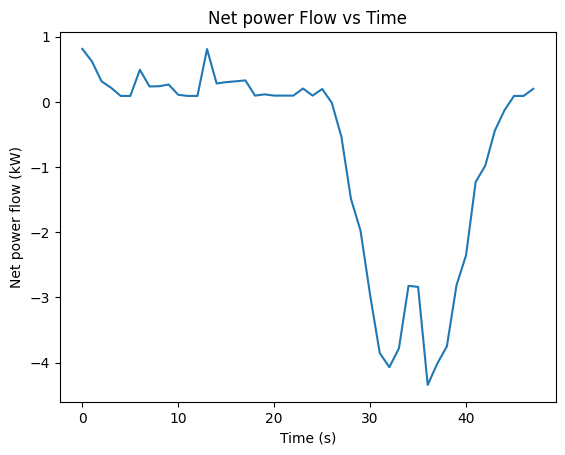

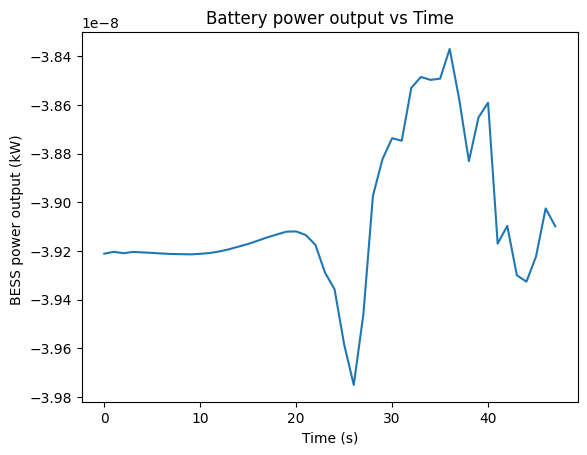

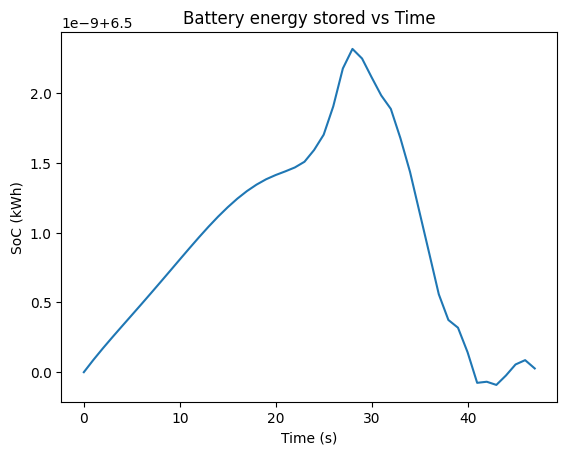

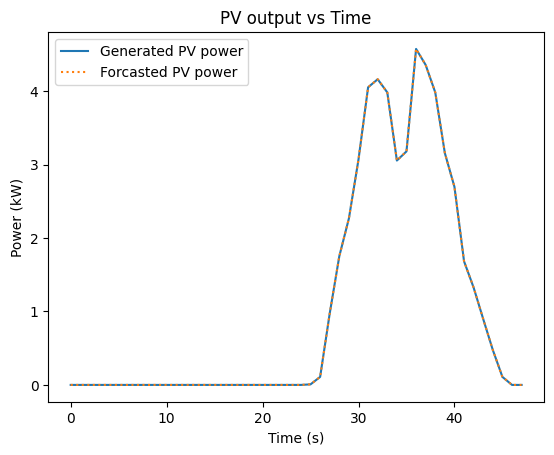

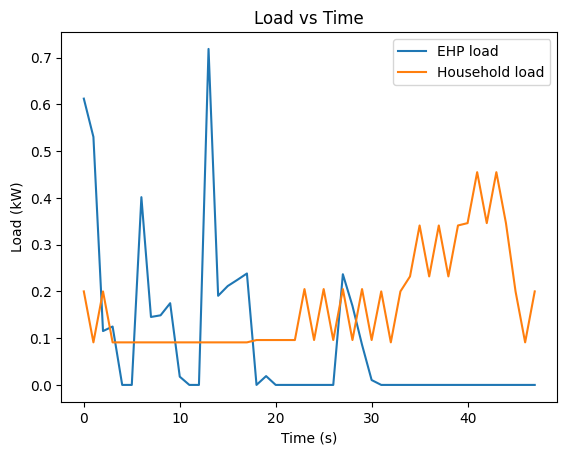

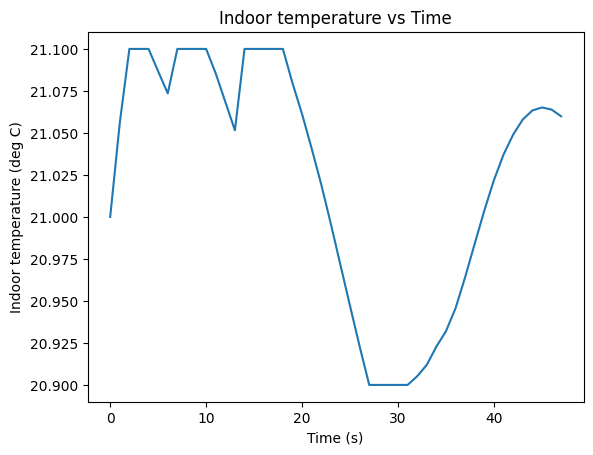

Total cost: -4.75
Total cost: -4.81
Total cost: -4.83
Total cost: -4.84
Total cost: -4.84
Total cost: -4.82
Total cost: -4.87
Total cost: -4.88
Total cost: -4.90
Total cost: -4.90
Total cost: -4.91
Total cost: -4.89
Total cost: -4.88
Total cost: -4.94
Total cost: -4.96
Total cost: -4.99
Total cost: -5.02
Total cost: -5.05
Total cost: -5.05
Total cost: -5.05
Total cost: -5.05
Total cost: -5.05
Total cost: -5.05
Total cost: -5.07
Total cost: -5.07
Total cost: -5.08
Total cost: -5.08
Total cost: -5.01
Total cost: -4.86
Total cost: -4.65
Total cost: -4.32
Total cost: -3.88
Total cost: -3.40
Total cost: -3.07
Total cost: -2.85
Total cost: -2.71
Total cost: -2.16
Total cost: -1.61
Total cost: -1.11
Total cost: -1.01
Total cost: -1.04
Total cost: -1.15
Total cost: -1.09
Total cost: -1.13
Total cost: -1.15
Total cost: -1.17
Total cost: -1.16
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


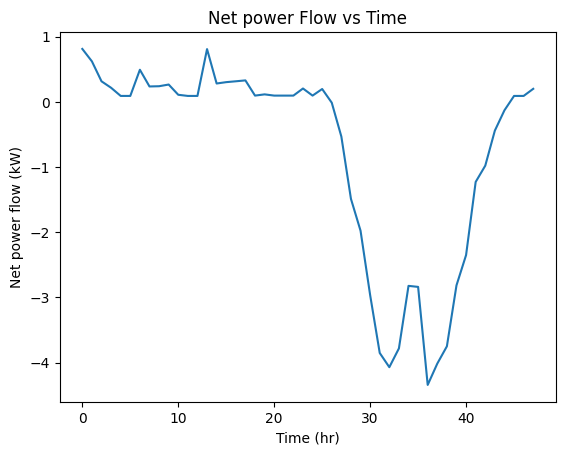

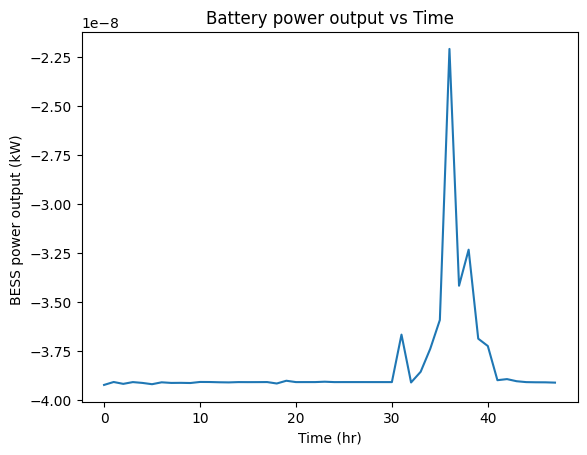

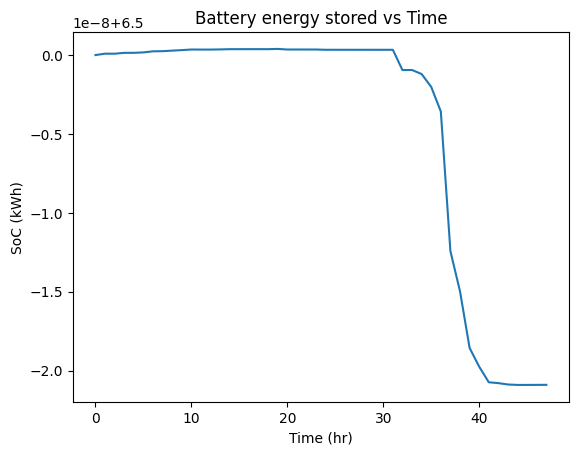

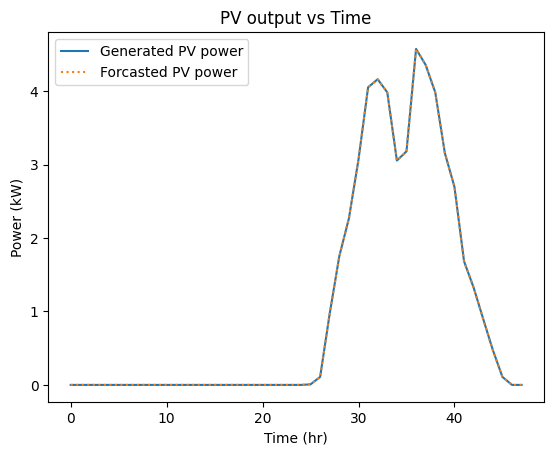

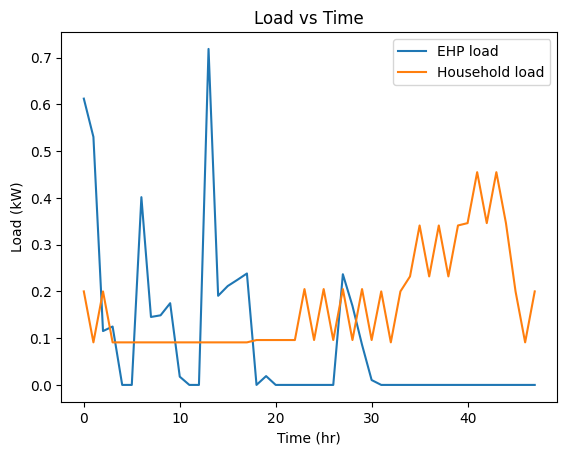

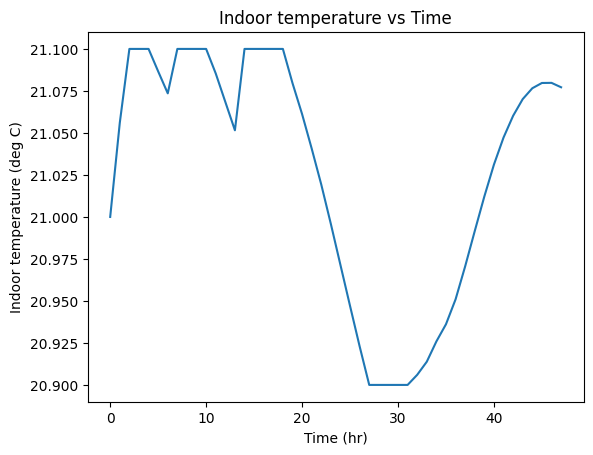

In [20]:
#checking the optimisation formula with real data
#Get updated data
df = pd.read_csv('data/solar_temp_austin/solar_temp.csv', sep=",")
df['datetime'] = df['UTC_DATE'].astype(str) + df['UTC_TIME'].astype(str).str.zfill(4)
# convert the combined column to datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d%H%M')
# set the datetime column as the index
df.set_index('datetime', inplace=True)
# drop the 'UTC_DATE' and 'UTC_TIME' columns
df = df.drop(['UTC_DATE', 'UTC_TIME', 'WABANNO', 'LST_DATE', 'CRX_VN', 'LONG', 'LAT'], axis=1)
#divide by 100 to convert to kW
Ins_PV_set = df['SOLAR_RAD'][11:-1:6]/1000
#start at 1:00am (to keep consistent) and increment by 6 5-minute intervals (half hour)
T_out_set = df['SURFACE_TEMP'][11:-1:6]

#read load
df = pd.read_csv('data/load_data/Electricity_Profile.csv', sep=",", header=None)
df = df.rename(columns={0: 'load'})
df['time'] = df.index%2400
freq_minutes = 1
n_rows = len(df)
date_col = pd.date_range(start='2023-01-01', periods=n_rows, freq=f'{freq_minutes}min')
df['datetime'] = date_col
df.set_index('datetime', inplace=True)
#start at 1:00am and increment by 30 minute intervals (half hour)
Load_set = df['load'][60:-1:30]/1000

##Inegration##
from online_batches import online_batches
from ml_models import ml_model

# Tarriffs 
tariff = 0.25

# Generate occupancy array
Occupancy = generate_occupancy_signal(time_array)

# Specify simulation length 
sim_length = 48

# Arrays for storing results
time = np.zeros(sim_length)
BESS_net = np.zeros(sim_length)
SoC = np.zeros(sim_length)
PV = np.zeros(sim_length)
PV_f = np.zeros(sim_length)
P_net = np.zeros(sim_length)
EHP =  np.zeros(sim_length)
temp_in = np.zeros(sim_length)

#run the MPC for 24 hours
c=controller()
for i in range(0, sim_length):

    #Used for testing with the ML model
    #increment the input data by 1 (24hr windows)
    T_out = T_out_set[i : i+48]
    Ins_PV = Ins_PV_set[i : i+48]
    Load = Load_set[i : i+48]

    # Run optimization model
    
    m = c.controller_model(T_out, Load, Ins_PV, tariff, Occupancy)

    # Store intital values
    # We want to use the first value but there is an error so we use the second untill it is finished.
    BESS_net[i] = value(m.BESS_net[1])
    SoC[i] = value(m.SoC[1])
    PV[i] = value(m.PV_gen[1])
    PV_f[i] = value(m.PV_f[1])
    P_net[i] = value(m.P_net[1])
    EHP[i] = value(m.ehp_E_input[1])
    temp_in[i] = value(m.temp[1])

    # Plot forecast (optional function for checking the otpimizer schedule)
    if (i==0):
        plot_forecast(m,time_array)  

    # Update Occcupancy array based on new time array
    Occupancy = update_occupancy(Occupancy, time_array) 

print(time_array)
# Plot P_in vs time
plt.plot(time_array, P_net)
plt.xlabel('Time (hr)')
plt.ylabel('Net power flow (kW)')
plt.title('Net power Flow vs Time')
plt.show()

# Plot BESS_net vs time
plt.plot(time_array, BESS_net)
plt.xlabel('Time (hr)')
plt.ylabel('BESS power output (kW) ')
plt.title('Battery power output vs Time')
plt.show()

# Plot SoC vs time
plt.plot(time_array, SoC)
plt.xlabel('Time (hr)')
plt.ylabel('SoC (kWh)')
plt.title('Battery energy stored vs Time')
plt.show()

# Plot PV vs time
plt.plot(time_array, PV, label='Generated PV power')
plt.plot(time_array, PV_f, linestyle='dotted', label='Forcasted PV power')
plt.xlabel('Time (hr)')
plt.ylabel('Power (kW)')
plt.title('PV output vs Time')
plt.legend()
plt.show()

# Load vs time
plt.plot(time_array, EHP, label='EHP load')
plt.plot(time_array, Load_set[0 : 48], label='Household load')
plt.xlabel('Time (hr)')
plt.ylabel('Load (kW)')
plt.title('Load vs Time')
plt.legend()
plt.show()

# Indoor temp vs time
plt.plot(time_array, temp_in)
plt.xlabel('Time (hr)')
plt.ylabel('Indoor temperature (deg C)')
plt.title('Indoor temperature vs Time')
plt.show()